In [87]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import matplotlib.cm as mcm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter
from matplotlib.colors import LogNorm
from epiweeks import Week
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
from countryinfo import CountryInfo
import itertools

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

mpl.rcParams['figure.dpi'] = 200

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

location_map = {
    "San Diego" : "#118ab2",
    "Baja California" : "#3A5A40",
    "Los Angeles" : "#ffd166",
    "United States" : "#ef476f",
    "Mexico" : "#073b4c",
    "Rest of World" : "#9e2a2b",
    "Random" : "#d9dbf1"
}

paired = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

In [37]:
# This is good for like 90% of all plots
def timeseries_formatting( ax, spines=["bottom"], which="y", title=None, ylabel=None, xlabel=None, xsize=12, ysize=12, xlims=None, ylims=None ):
    # Properly label timeseries
    ax.xaxis.set_minor_locator( mdates.MonthLocator() )
    ax.xaxis.set_minor_formatter( mdates.DateFormatter( '%b' ) )
    ax.xaxis.set_major_locator( mdates.YearLocator() )
    ax.xaxis.set_major_formatter( mdates.DateFormatter( '%Y %b' ) )

    # Remove spines
    [ax.spines[j].set_visible(False) for j in ax.spines if j not in spines]

    # Format axes ticks
    ax.tick_params( axis="x", bottom=False, which="both", rotation=90, labelbottom=True, labelsize=xsize )
    ax.tick_params( axis="y", left=False, which="both", labelleft=True, labelsize=ysize )

    # Label axes
    ax.set_xlabel( xlabel, fontsize=xsize )
    ax.set_ylabel( ylabel, fontsize=ysize )
    ax.set_title( title)

    # Add a simple grid
    ax.grid( which="both", axis=which, linewidth=1, color="#F1F1F1", zorder=1 )

    # Add the xlims
    if xlims:
        ax.set_xlim( xlims )
    if ylims:
        ax.set_ylim( ylims )

def format_for_focus( input_df, focus ):
    df = input_df.copy()
    df["to"] = df["col"]
    df["from"] = df["row"]
    df.loc[df["row"]==focus,"to"] = focus
    df.loc[df["row"]==focus,"from"] = df.loc[df["row"]==focus,"col"]
    df = df.loc[df["to"]==focus]
    return df

# Load the data

In [7]:
def load_data( directory, actual="phylosor" ):
    files = [i for i in os.listdir( directory ) if i.endswith( ".csv" )]
    combined_df = list()
    for i in files:
        temp = pd.read_csv( os.path.join( directory, i ), parse_dates=["date"] )
        temp["file"] = os.path.splitext( i )[0]
        temp = temp.drop( columns="Unnamed: 0" )
        combined_df.append( temp )
    combined_df = pd.concat( combined_df )

    acts = combined_df.loc[combined_df["file"]==actual]
    ns = combined_df.loc[combined_df["file"]!=actual]
    ns = ns.groupby( ["col", "row", "date"] )["value"].agg(
        null_90=lambda x: x.quantile( 0.9 ),
        null_10=lambda x: x.quantile( 0.1 ),
        null_mean="mean",
        null_std="std" )
    acts = acts.merge( ns, left_on=["col", "row", "date"], right_index=True, validate="1:1" )
    acts["corrected_div"] = acts["value"] / acts["null_90"]
    acts["corrected_sub"] = acts["null_90"] - acts["value"]
    acts["corrected_z"] = (acts["value"] - acts["null_mean"]) / acts["null_std"]

    return combined_df, acts, ns
phy, actual, nulls = load_data( "../data/border_3", actual="border_3_actual" )
phy.head()

,col,row,value,row_count,col_count,date,file
0,Baja California,Baja California Sur,NaN,0,0,2020-01-27,border_3_actual
1,Baja California,British Columbia,0.0,1,0,2020-01-27,border_3_actual
2,Baja California,Malaysia,0.0,3,0,2020-01-27,border_3_actual
3,Baja California,Chihuahua,NaN,0,0,2020-01-27,border_3_actual
4,Baja California,Ontario,NaN,0,0,2020-01-27,border_3_actual


In [67]:
# Load metadata
seqs = !gotree labels < ../data/border_3/border_3_pruned.tree | cut -f3 -d\|
md = pd.read_csv( "../data/border_3/border_metadata.csv", parse_dates=["date_collected"] )
md = md.loc[md["accession_id"].isin( seqs )]
md["epiweek"] = md["date_collected"].apply( lambda x: Week.fromdate(x).startdate() )
md.head()

,strain,accession_id,date_collected,pangolin_lineage,country,division,location,site,long_name,epiweek
2,hCoV-19/Malaysia/IIUM5676/2021,EPI_ISL_2622045,2021-04-23,B.1.524,Malaysia,Pahang,None,Malaysia,MYS|Pahang|EPI_ISL_2622045|2021-04-23,2021-04-18
6,hCoV-19/Singapore/2729/2021,EPI_ISL_3188757,2021-07-27,AY.23,Singapore,Singapore,None,Singapore,SGP|Singapore|EPI_ISL_3188757|2021-07-27,2021-07-25
10,hCoV-19/USA/CA-CSMC327/2021,EPI_ISL_7509054,2021-02-06,B.1.429,United States,California,Los Angeles,Los Angeles,USA|California-LosAngeles|EPI_ISL_7509054|2021...,2021-01-31
11,hCoV-19/USA/CA-CDPH-2000024496/2021,EPI_ISL_3722572,2021-01-11,B.1.429,United States,California,Santa Clara,Santa Clara,USA|California-SantaClara|EPI_ISL_3722572|2021...,2021-01-10
14,hCoV-19/USA/CA-CZB-13330/2020,EPI_ISL_2659327,2020-11-02,B.1.399,United States,California,Santa Clara,Santa Clara,USA|California-SantaClara|EPI_ISL_2659327|2020...,2020-11-01


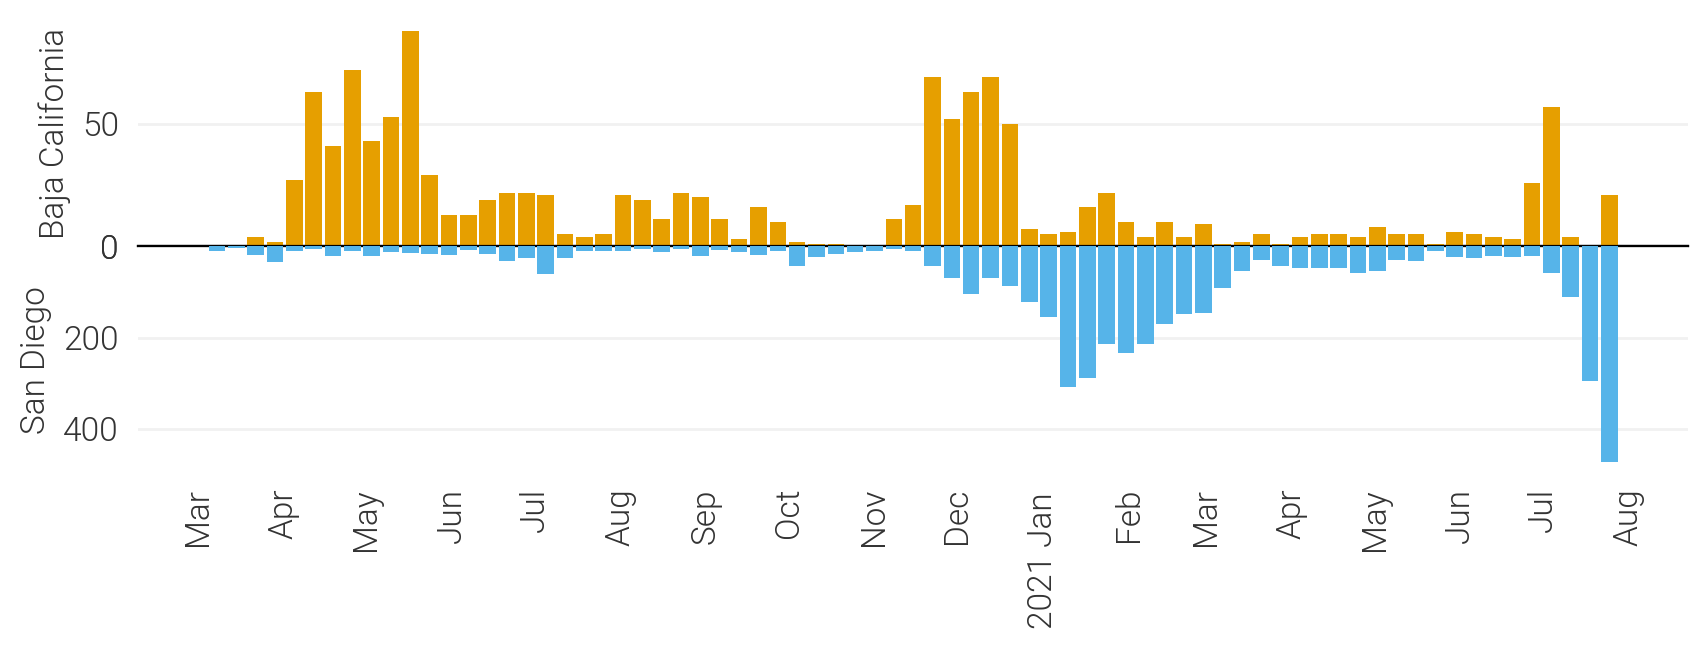

In [70]:
def plot_sampling( axis, df, colors=["#E69F00", "#56B4E9"], order=None, fixed=False ):
    plot_df = df.pivot_table( index="epiweek", columns="site", values="pangolin_lineage", aggfunc="count" ).fillna(0.0)

    if order:
        plots = [plot_df[i] for i in order]
    else:
        plots = [plot_df.iloc[:,0], plot_df.iloc[:,1]]

    axis.bar( x=plot_df.index, height=plots[0], color=colors[0], width=6, zorder=10 )

    divider = make_axes_locatable( axis )
    axis2 = divider.append_axes( "bottom", size="100%", pad=0, sharex=axis )
    axis2.bar( x=plot_df.index, height=plots[1], color=colors[1], width=6, zorder=10 )

    if fixed:
        if axis.get_ylim() < axis2.get_ylim():
            axis.set_ylim( axis2.get_ylim() )
        else:
            axis2.set_ylim( axis.get_ylim() )

    axis2.invert_yaxis()

    timeseries_formatting( axis )
    timeseries_formatting( axis2, spines=["top"] )
    axis.tick_params( which="both", labelbottom=False )
    axis.set_ylabel( plots[0].name )
    axis2.set_ylabel( plots[1].name )

fig, ax = plt.subplots( dpi=200, figsize=(10,3) )
plot_sampling( ax, md.loc[md["site"].isin( ["San Diego", "Baja California"] )] )
plt.show()

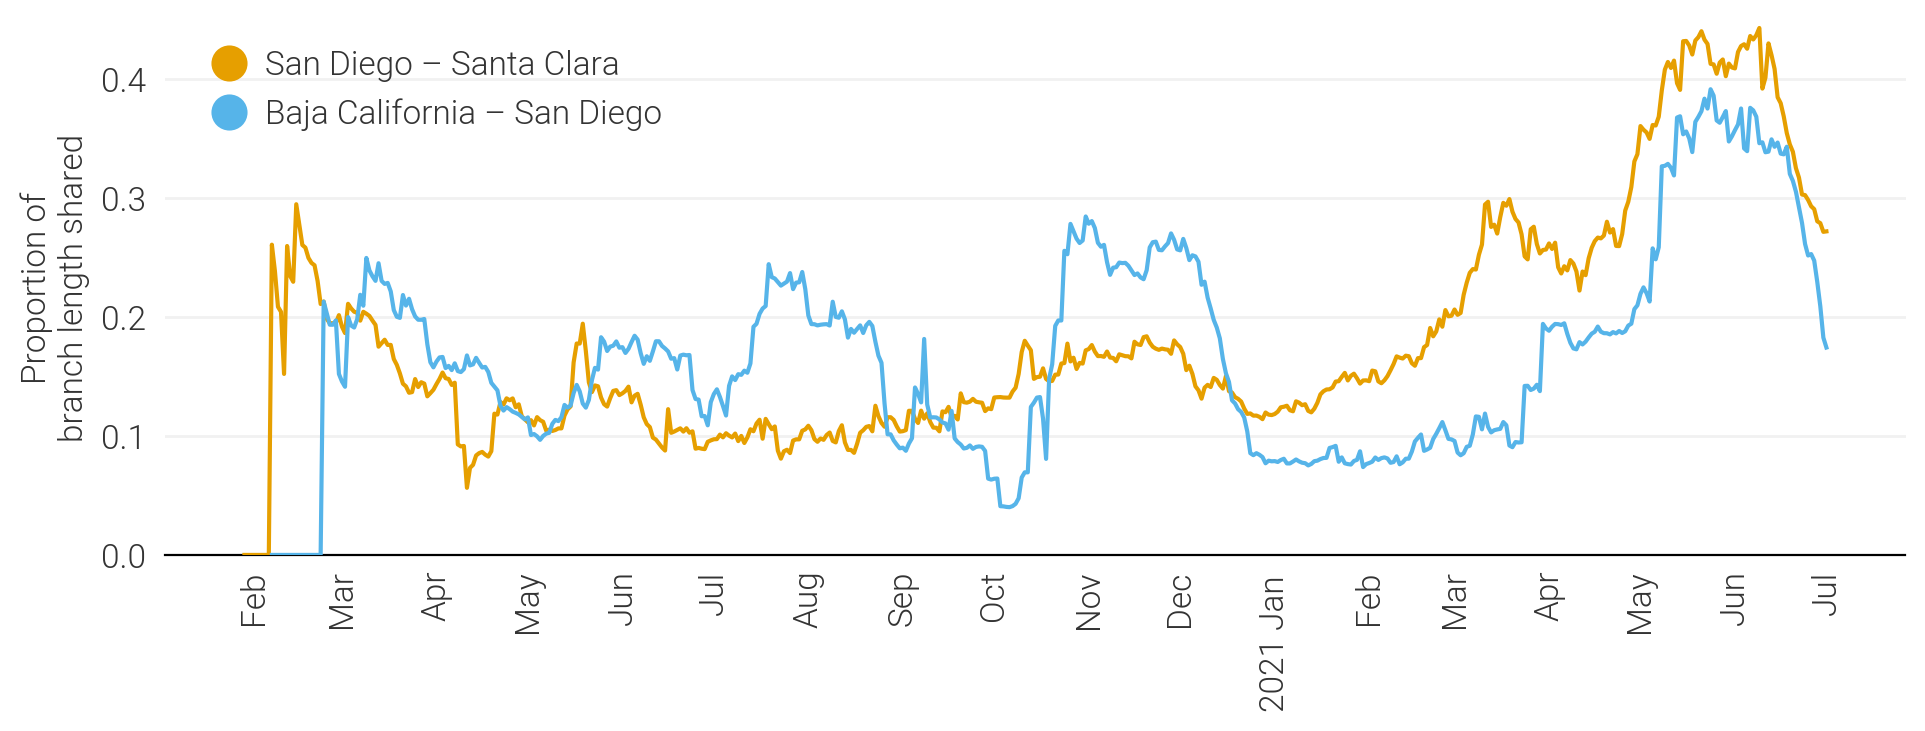

In [108]:
def plot_phylosor_nulls( axis, df, focus, color, missing=True, title=False ):
    plot_df = format_for_focus( df, focus[0] )
    plot_df = plot_df.loc[plot_df["from"]==focus[1]].dropna()

    colors_needed = len( plot_df["file"].unique() ) - 1
    colors = reversed( [color] + ["#DBDBDB"] * colors_needed )

    for i, col in zip( sorted( plot_df["file"].unique(), reverse=True ), colors ):
        axis.plot( "date", "value", color=col, data=plot_df.loc[plot_df["file"]==i] )

    legend = [Line2D([0], [0], linestyle='none', marker='o', color=color, label="True locations", markersize=12 ),
              Line2D([0], [0], linestyle='none', marker='o', color="#DBDBDB", label="Shuffled locations", markersize=12 )]
    axis.legend( loc="upper left", handletextpad=0.1, handles=legend, frameon=False, fontsize=12 )

    if title:
        axis.set_title( " and ".join( focus ), loc="left" )

def plot_phylosor( axis, df, focus, color, actual, missing=True, normalized=False ):
    plotting_values = { False: "value",
                        "z" : "corrected_z",
                        "sub" : "corrected_sub",
                        "div" : "corrected_div" }
    pvalue = plotting_values[normalized]

    plot_df = format_for_focus( df, focus[0] )
    plot_df = plot_df.loc[(plot_df["to"]==focus[0])&(plot_df["from"]==focus[1])].dropna()
    if not normalized:
        plot_df = plot_df.loc[plot_df["file"]==actual]

    if not missing:
        plot_df.loc[plot_df["value"]==0,"value"] = np.nan
        plot_df = plot_df.loc[~plot_df["value"].isna()]

    axis.plot( "date", pvalue, color=color, data=plot_df, zorder=10 )

def plot_phylosors( axis, df, focuses, actual, colors, missing=True, normalized=False ):
    legend = list()
    for i, j in zip( focuses, colors ):
        plot_phylosor( axis, df, i, j, actual=actual, missing=missing, normalized=normalized )
        legend.append( Line2D([0], [0], linestyle='none', marker='o', color=j, label=" – ".join( i ), markersize=12 ) )
    axis.legend( handletextpad=0.1, handles=legend, frameon=False, fontsize=12 )

fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
plot_phylosors( ax, phy, [('San Diego', "Santa Clara"),('Baja California', "San Diego")], actual="border_3_actual",colors=paired[:2] )
timeseries_formatting( ax, ylabel="Proportion of\nbranch length shared", ylims=(0,0.45) )
plt.tight_layout()
plt.show()

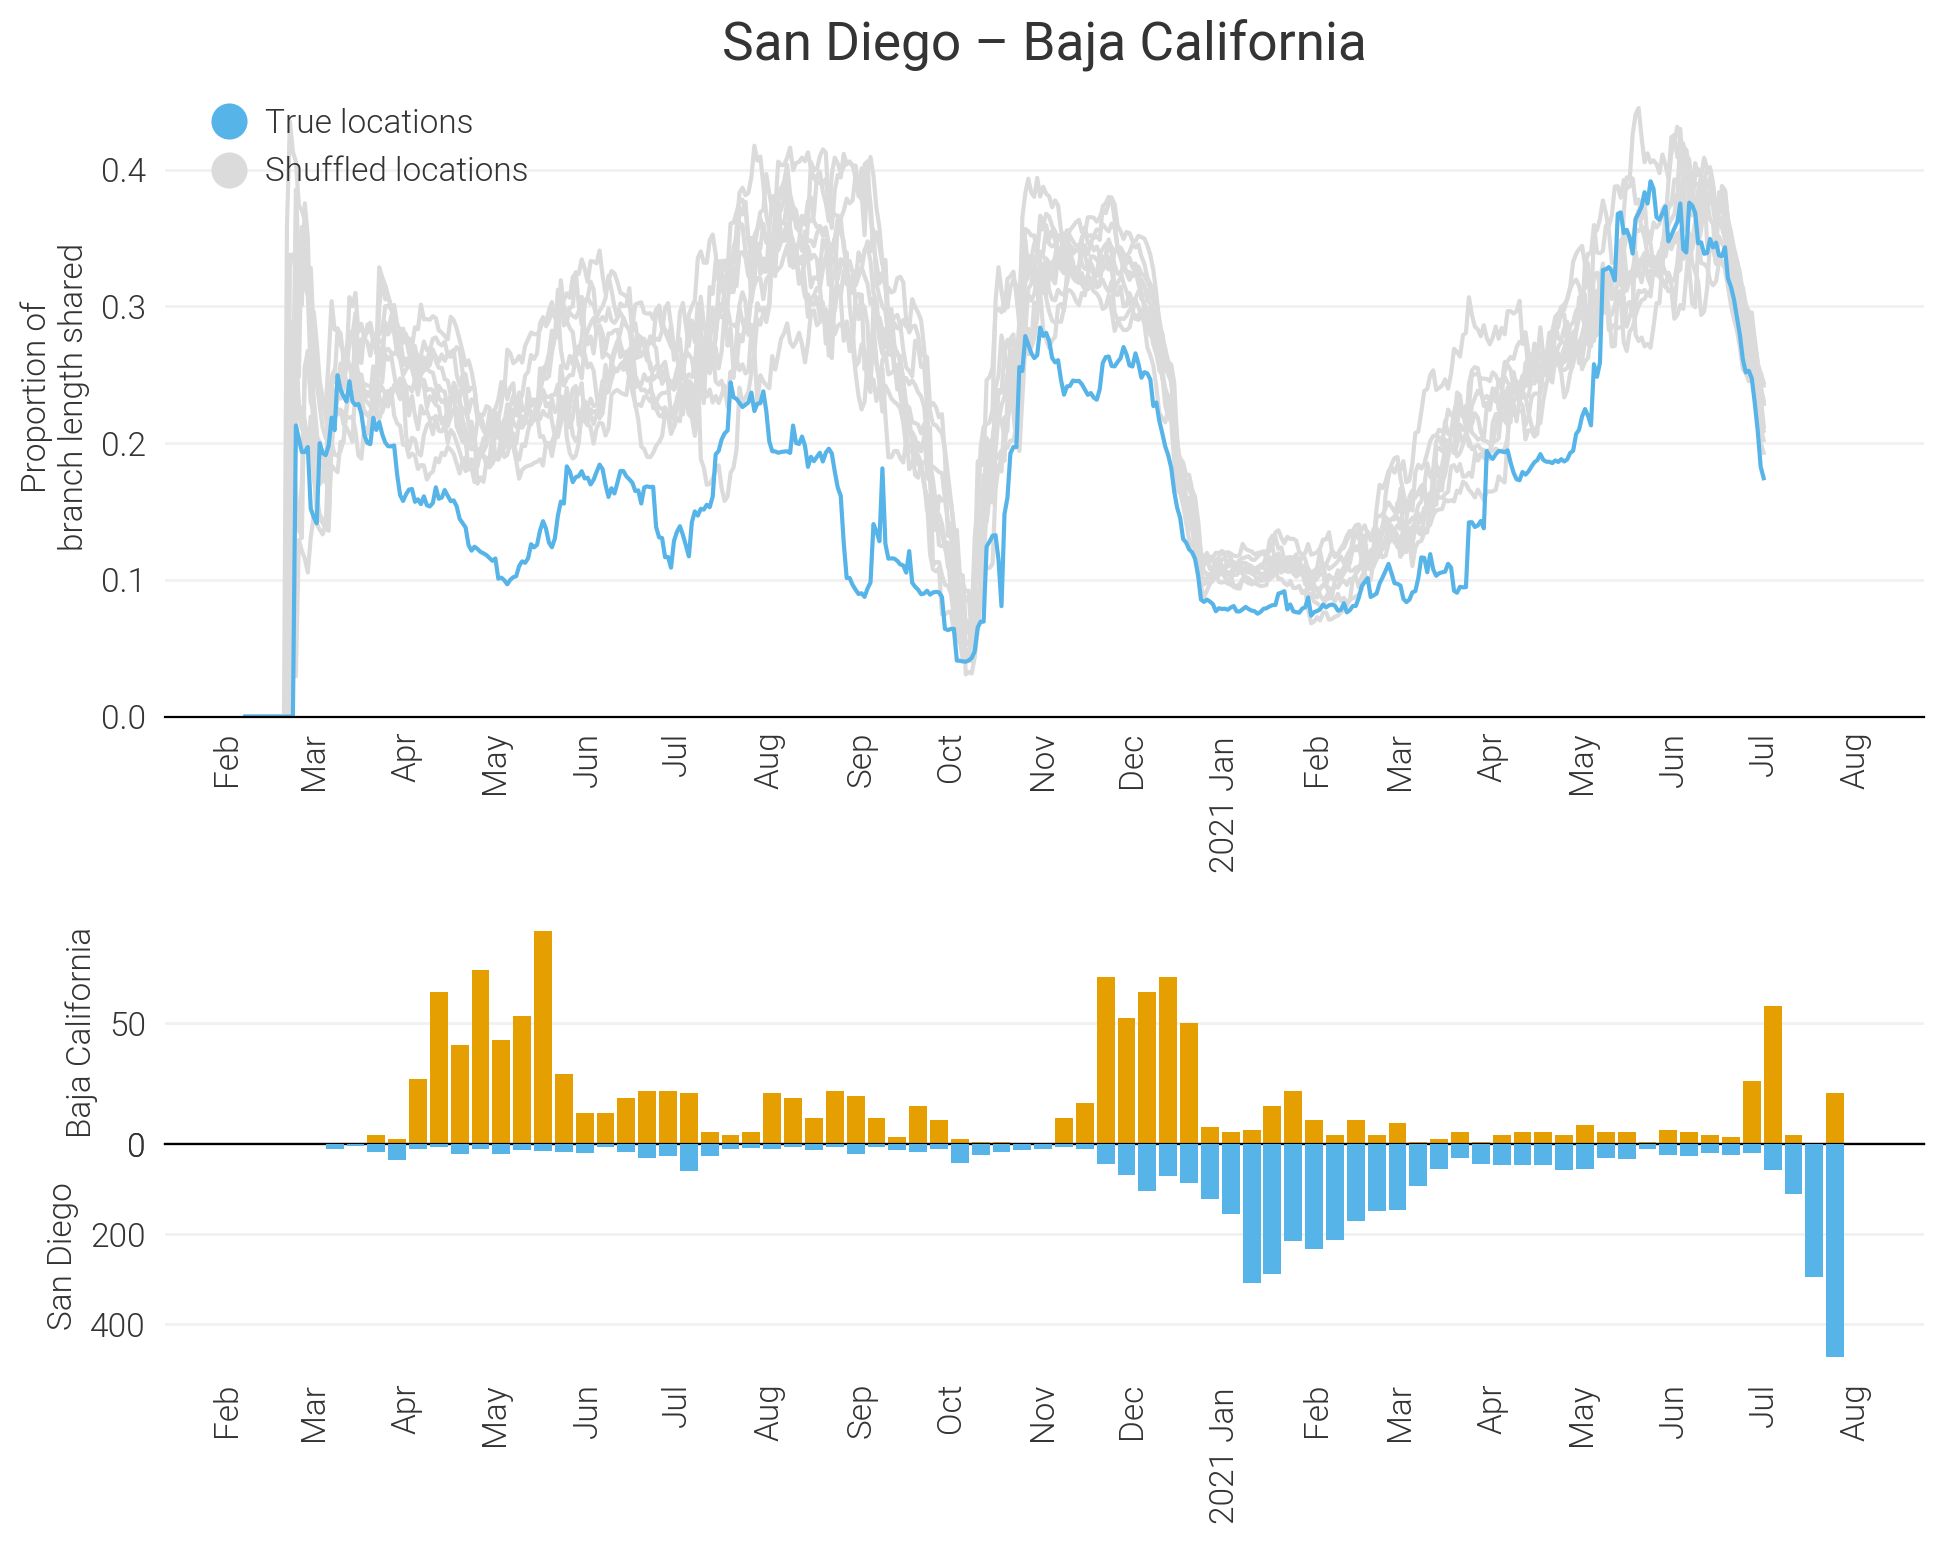

In [85]:
query = ('San Diego', "Baja California")

fig, ax = plt.subplots( dpi=200, figsize=(10,8), nrows=2, sharex=True, gridspec_kw={"height_ratios" : (1, 0.7)} )
plot_phylosor_nulls( ax[0], phy, query, color=paired[1] )
timeseries_formatting( ax[0], ylabel="Proportion of\nbranch length shared" )
ax[0].set_ylim( 0 )
plot_sampling( ax[1], md.loc[md["site"].isin( query )] )
ax[0].set_title( " – ".join( query ) )
plt.tight_layout()
plt.show()

In [93]:
for query in itertools.combinations( sorted( md["site"].unique() ), 2 ):
    name = "-".join( query )
    name = name.replace( " ", "" )
    fig, ax = plt.subplots( dpi=200, figsize=(10,8), nrows=2, sharex=True, gridspec_kw={"height_ratios" : (1, 0.7)} )
    plot_phylosor_nulls( ax[0], phy, query, color=paired[1] )
    timeseries_formatting( ax[0], ylabel="Proportion of\nbranch length shared" )
    ax[0].set_ylim( 0 )
    plot_sampling( ax[1], md.loc[md["site"].isin( query )] )
    ax[0].set_title( " – ".join( query ) )
    plt.tight_layout()
    plt.savefig( f"/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/figures/border_3/{name}_comparison.jpg" )
    plt.close()

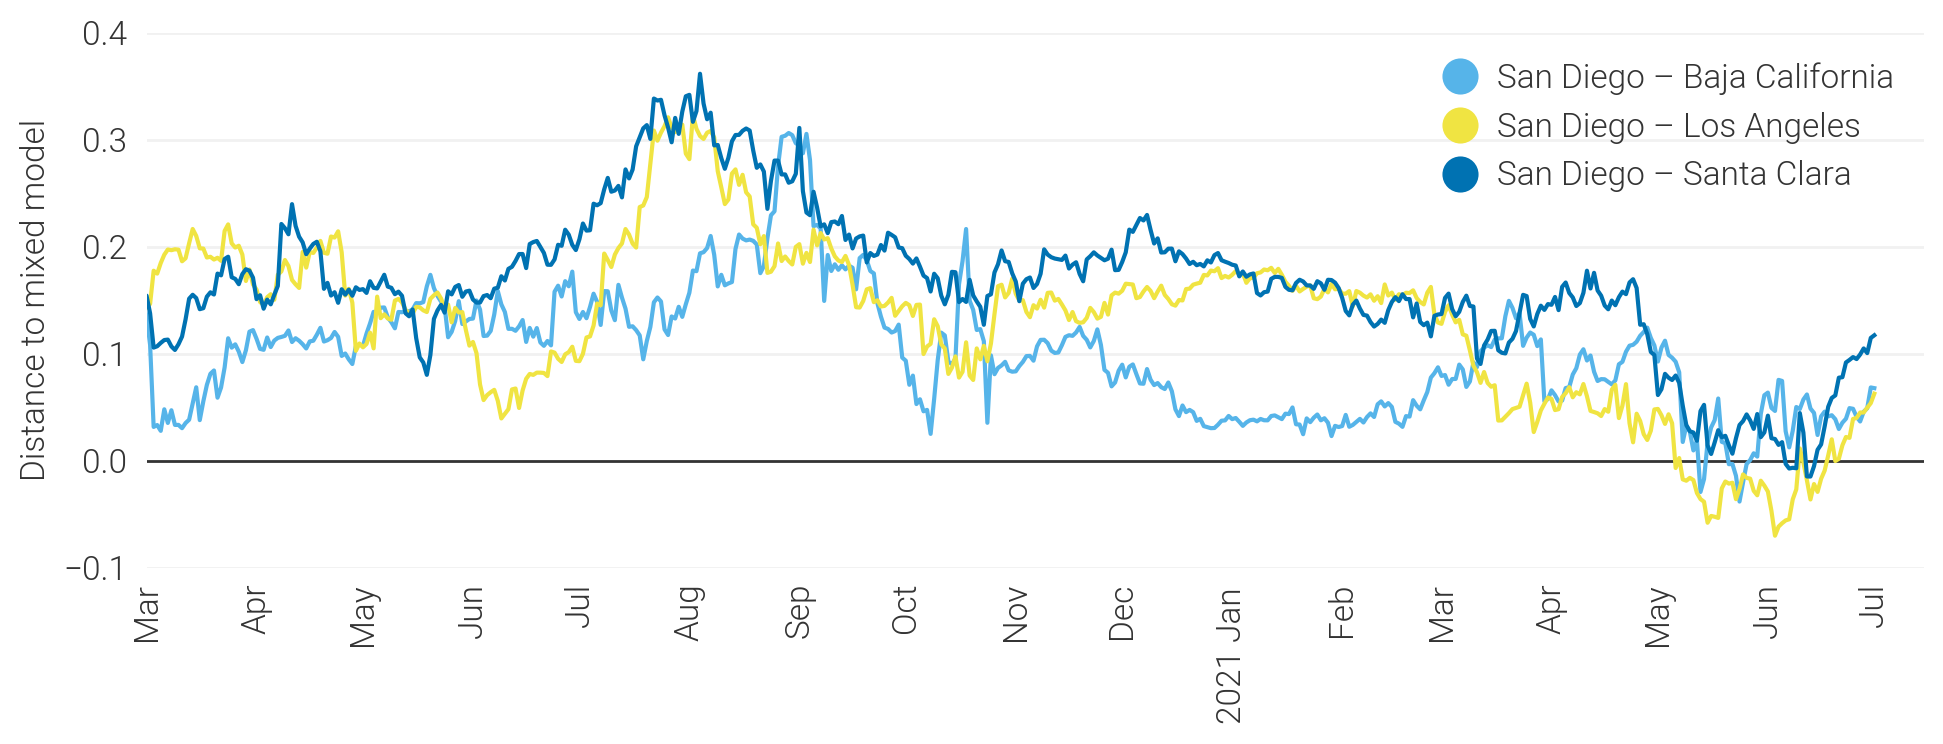

In [105]:
fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
plot_phylosors( ax, actual, [('San Diego', "Baja California"),('San Diego', "Los Angeles"),('San Diego', "Santa Clara")], actual="border_3_actual", colors=['#56B4E9','#F0E442','#0072B2'], normalized="sub", missing=False )
ax.axhline(0, linewidth=1, color='#343434', zorder=2 )
timeseries_formatting( ax, spines=[], ylabel="Distance to mixed model", xlims=(pd.to_datetime("2020-03-01"), pd.to_datetime("2021-07-15") ), ylims=(-0.1, 0.4) )
ax.get_legend()
plt.tight_layout()

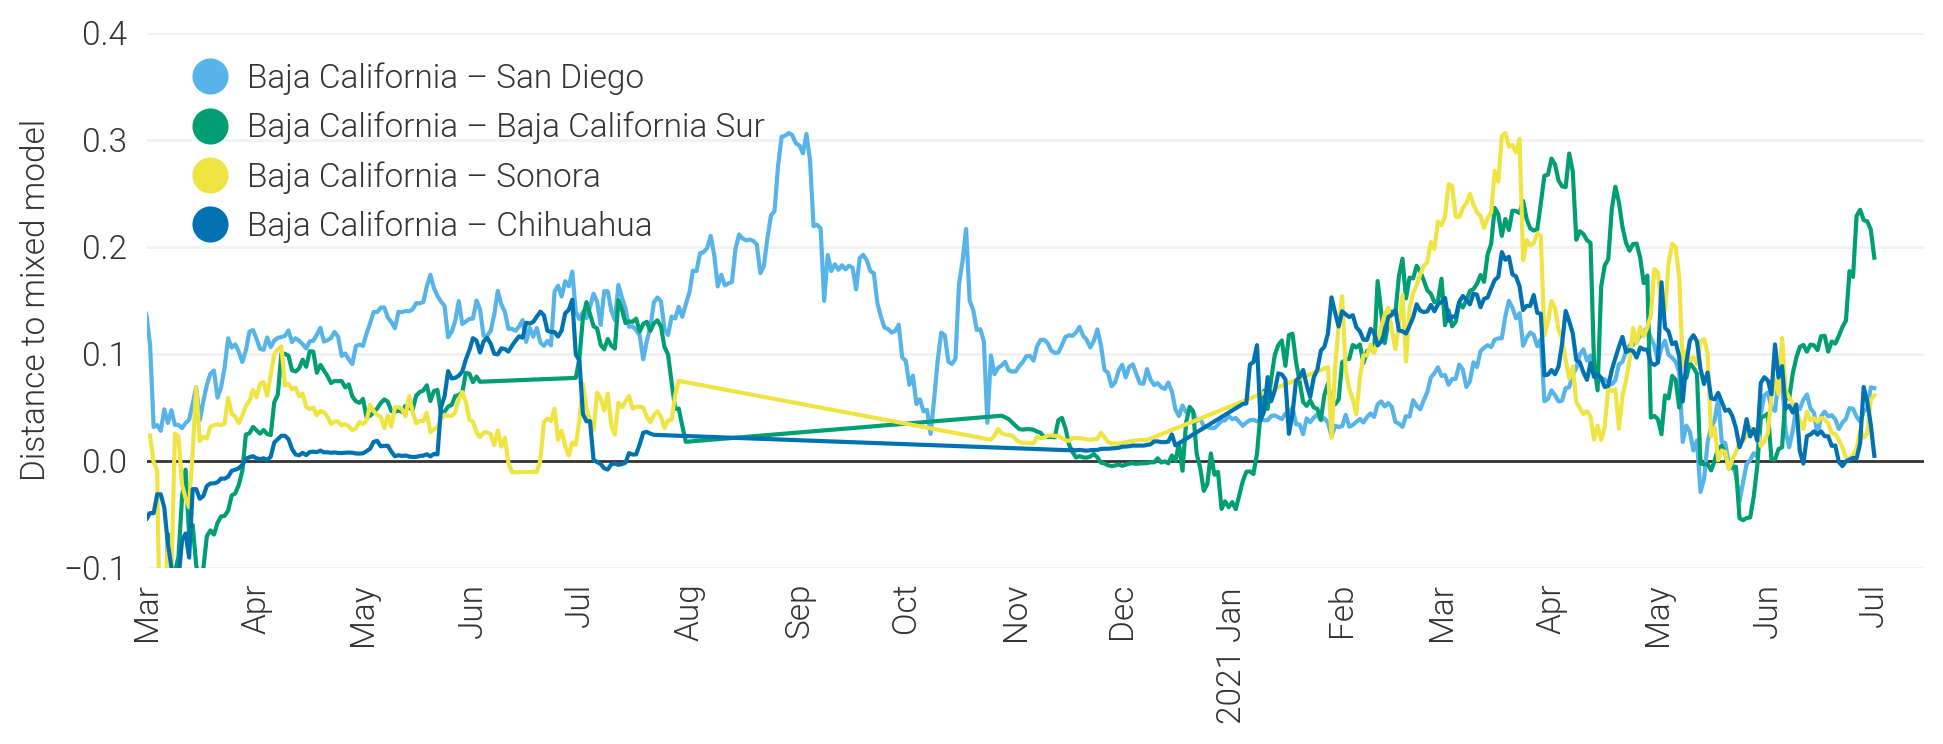

In [110]:
fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
plot_phylosors( ax, actual, [("Baja California", "San Diego"),('Baja California', "Baja California Sur"),('Baja California', "Sonora"), ('Baja California', "Chihuahua")], actual="border_3_actual", colors=['#56B4E9','#009E73', '#F0E442', '#0072B2'], normalized="sub", missing=False )
ax.axhline(0, linewidth=1, color='#343434', zorder=2 )
timeseries_formatting( ax, spines=[], ylabel="Distance to mixed model", xlims=(pd.to_datetime("2020-03-01"), pd.to_datetime("2021-07-15") ), ylims=(-0.1, 0.4) )
ax.get_legend()
plt.tight_layout()

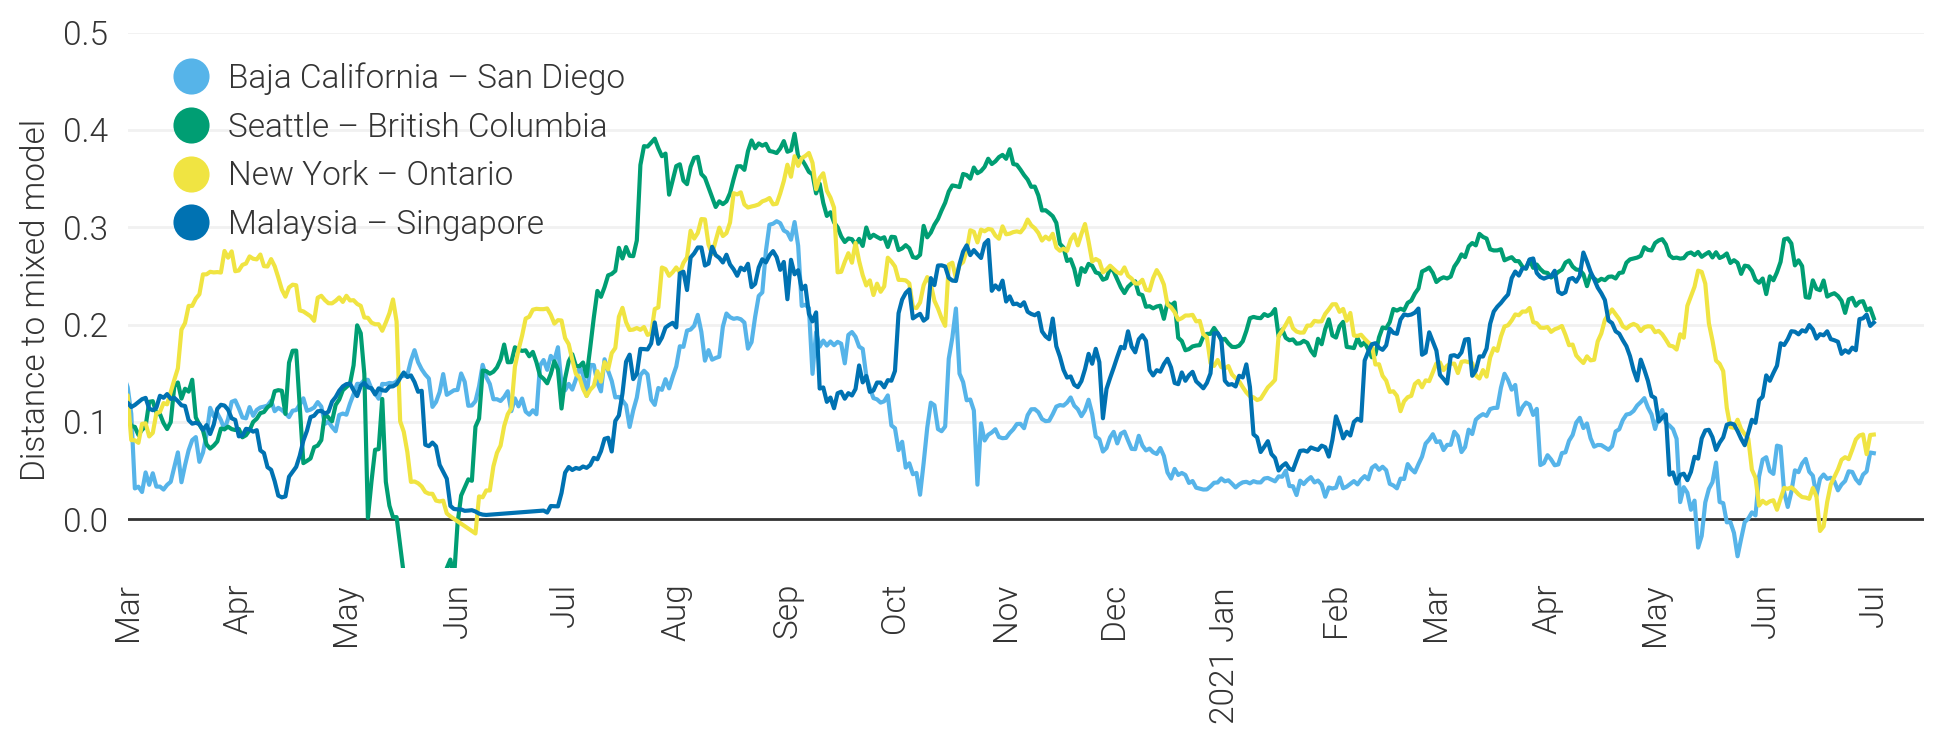

In [127]:
fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
plot_phylosors( ax, actual, [("Baja California", "San Diego"),('Seattle', "British Columbia"),('New York', "Ontario"), ('Malaysia', "Singapore")], actual="border_3_actual", colors=['#56B4E9','#009E73', '#F0E442', '#0072B2'], normalized="sub", missing=False )
ax.axhline(0, linewidth=1, color='#343434', zorder=2 )
timeseries_formatting( ax, spines=[], ylabel="Distance to mixed model", xlims=(pd.to_datetime("2020-03-01"), pd.to_datetime("2021-07-15")), ylims=(-0.05, 0.5) )
plt.tight_layout()
plt.savefig( "../figures/border_3/international_borders.pdf" )

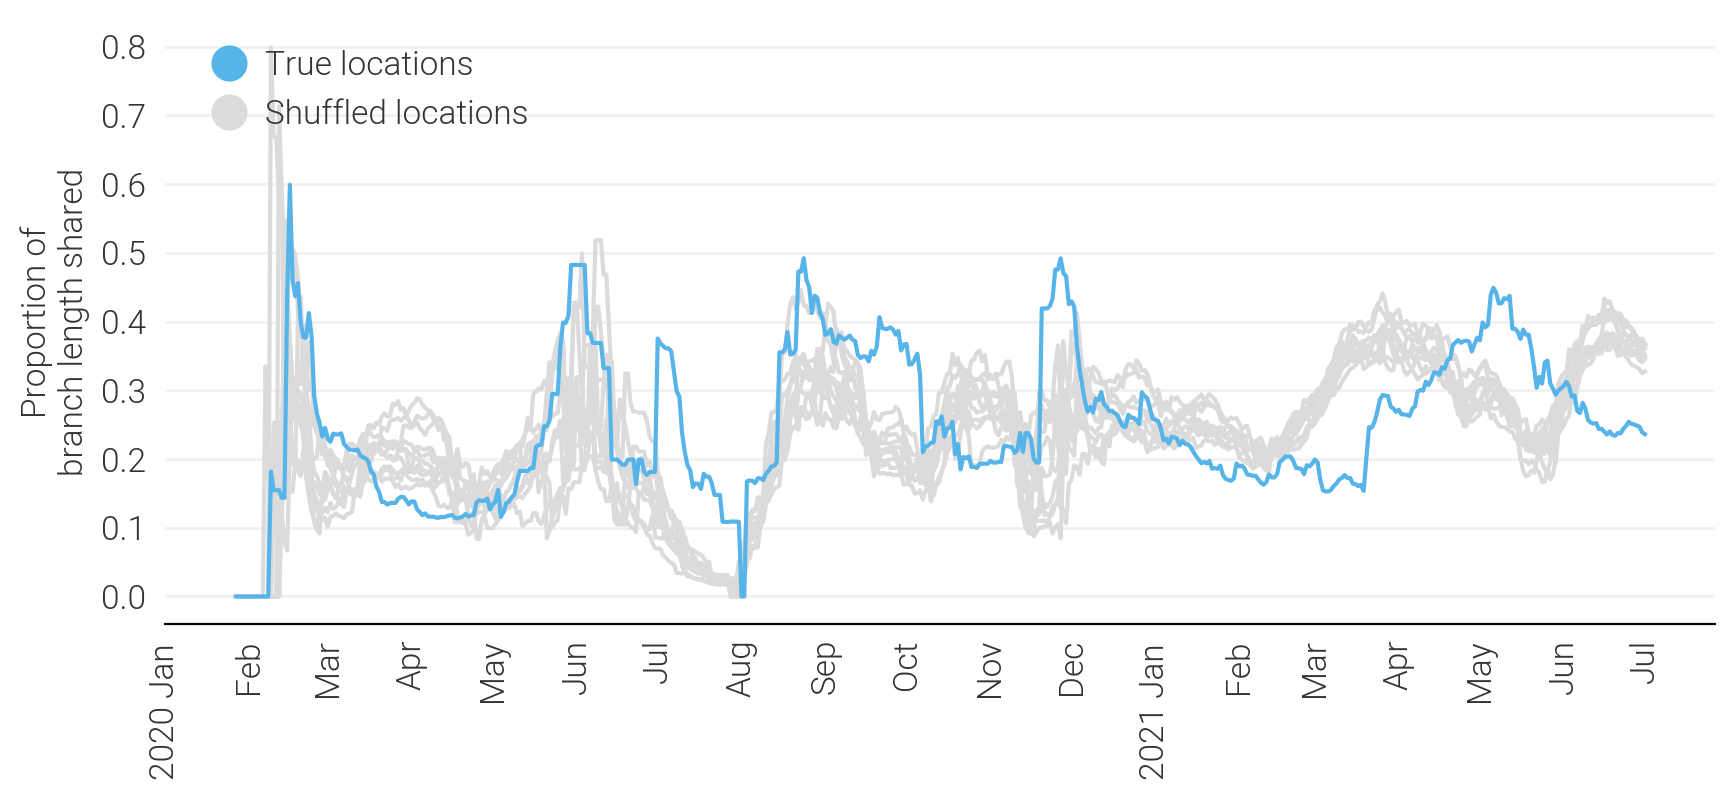

In [123]:
fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
plot_phylosor_nulls( ax, phy, ('Ireland', "Northern Ireland"), color=paired[1], missing=False )
timeseries_formatting( ax, ylabel="Proportion of\nbranch length shared" )